In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

Set working directory

In [2]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/'
workingDirectory = '/home/h1bennet/brain_aging/results/04_Young_Cell_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

Read in color scheme

In [3]:
hex_dict={}
rgb_dict={}
for line in open('/gpfs/data01/glasslab/home/h1bennet/brain_aging/data/brain_aging_color_table.txt','r'):
    split = line.strip().replace('\ufeff','').split('\t')
    # split2 = split[1]
    hex_dict[split[0]] = split[1]
    rgb_dict[split[0]] = split[2]   

### Read in raw gene expression files

In [4]:
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_idr_vw_peaks_merged.txt')

In [5]:
#  mat.columns

In [6]:
best_reps = ['03_mouse_MPSIIIAhet_M_4mongh_Olig2_ChIP_H3K27ac_1_AL_l20200925_CTCACCAA_CTAGGCAA',
       '03_mouse_MPSIIIAhet_M_4month_Olig2_ChIP_H3K27ac_2_AL_l20200925_GTGAATAT_TCTCATTC',
       '03_mouse_MPSIIIAhet_M_4month_Olig2_ChIP_H3K27ac_3_AL_20201111_GGTCACGA_GTATTATG',
       '04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_1_AL_l20200925_ACAGGCGC_CTCTGCCT',
       '04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_2_AL_l20200925_GAACCGCG_TGACCTTA',
       '04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_3_AL_l20200925_TGCGAGAC_CATTGTTG',
       '04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_4_AL_20201111_AACTGTAG_ACGCCGCA',
       '04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_5_AL_20201121_TACCGAGG_CCTGAACT',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG',
       '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC',
       '03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_1_AL_20200925_CATAGAGT_TGCCACCA',
       '03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_2_AL_20201121_AATGCCTC_TCGATCCA']

In [7]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_idr_vw_peaks_merged.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]

df.to_csv('./merged_peaks/ann_raw_idr_vw_peaks_merged_filtered.txt', sep='\t')

In [8]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./merged_peaks/ann_raw_idr_vw_peaks_merged_filtered.txt \
# 00_olig2_4month 00_olig2_4month 00_olig2_4month \
# 01_neun_4month 01_neun_4month 01_neun_4month 01_neun_4month 01_neun_4month \
# 02_pu1_4month 02_pu1_4month 02_pu1_4month \
# 03_sox9 03_sox9 \
# -peaks -AvsA > ./diff_vw_output.txt


### Import differential peaks

In [9]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_vw_output.txt',
    './merged_peaks/ann_raw_idr_vw_peaks_merged.txt')


annotatePeaks all peaks (80008, 31)
getDiffExpression selected transcripts (78242, 49)
annotatePeaks selected peaks (78242, 31)


In [52]:
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)
diff_peak.sort_values('00_olig2_4month vs. 02_pu1_4month adj. p-value', ascending=True).head()

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,01_neun_4month vs. 02_pu1_4month Log2 Fold Change,01_neun_4month vs. 02_pu1_4month p-value,01_neun_4month vs. 02_pu1_4month adj. p-value,01_neun_4month vs. 03_sox9 Log2 Fold Change,01_neun_4month vs. 03_sox9 p-value,01_neun_4month vs. 03_sox9 adj. p-value,02_pu1_4month vs. 03_sox9 Log2 Fold Change,02_pu1_4month vs. 03_sox9 p-value,02_pu1_4month vs. 03_sox9 adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr1-87647831-9,chr1,87619394,87672184,+,2839.333252,./peak_files/04_mouse_MPSIIIAhet_M_4month_NeuN...,"intron (NM_001110192, intron 2 of 26)","intron (NM_001110192, intron 2 of 26)",25477.0,NM_010566,...,6.637378,5.101423e-250,1.995651e-245,0.551510,1.288854e-02,2.577477e-02,-6.088377,1.447459e-95,3.116380e-91,chr1:87619394-87672184
Merged-chr4-136887840-4,chr4,136878435,136900371,+,4351.600098,./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_...,TTS (NM_007574),TTS (NM_007574),-3226.0,NM_009777,...,8.515555,9.320775e-157,8.102757e-154,1.483681,3.445690e-04,1.007206e-03,-7.039799,1.442724e-103,4.659277e-99,chr4:136878435-136900371
Merged-chr15-79188204-12,chr15,79147813,79226627,+,2541.066650,./peak_files/03_mouse_MPSIIIAhet_M_4mongh_Olig...,"intron (NR_029470, intron 2 of 4)",B1_Mm|SINE|Alu,21154.0,NR_029470,...,0.631700,3.917101e-02,6.342379e-02,2.289659,3.396668e-15,3.780255e-14,1.653952,9.042843e-08,5.897741e-07,chr15:79147813-79226627
Merged-chr9-45261695-4,chr9,45240797,45284431,+,4447.025391,./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_...,"intron (NR_136903, intron 4 of 5)","intron (NR_136903, intron 4 of 5)",4093.0,NR_106054,...,7.512172,1.770991e-148,1.145128e-145,1.497168,1.593373e-05,5.964494e-05,-6.022533,1.142952e-84,1.054618e-80,chr9:45240797-45284431
Merged-chr10-60358009-8,chr10,60340950,60380560,+,2135.812500,./peak_files/03_mouse_MPSIIIAhet_M_4month_SOX9...,"intron (NM_028732, intron 3 of 6)","intron (NM_028732, intron 3 of 6)",13904.0,NM_028732,...,7.026597,7.312831e-169,9.697434e-166,2.733140,1.291332e-24,2.776381e-23,-4.286632,3.140345e-51,7.568465e-49,chr10:60340950-60380560


In [11]:
# pull out selected samples
cols = np.append(np.asarray([True]*18, 'bool'), peak_mat.columns.str.contains('|'.join(best_reps)))
peaks = peaks.loc[:, cols]
peak_mat = peak_mat.loc[:, peak_mat.columns.str.contains('|'.join(best_reps))]

In [12]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [13]:
comps = ['00_olig2_4month vs. 01_neun_4month',
         '00_olig2_4month vs. 02_pu1_4month',
         '00_olig2_4month vs. 03_sox9',
         '01_neun_4month vs. 02_pu1_4month',
         '01_neun_4month vs. 03_sox9',
         '02_pu1_4month vs. 03_sox9']

cols = [[0,1,2],
        [],
        [0,1,7,8],
        [2,3,4,5,6],
        [2,3,4,7,8],
        [5,6,7,8]]

groups = [[[0,1,2],[3,4,5,6,7]],
        [[0,1,2],[8,9,10]],
        [[0,1,2],[11,12]],
        [[3,4,5,6,7],[8,9,10]],
        [[3,4,5,6,7],[11,12]],
        [[8,9,10],[11,12]]]

cols = []
for i in groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    cols.append(subcols)

colors = [['#31a354', '#dd1c77'],
          ['#31a354', '#3182bd'],
          ['#31a354', '#e6550d'],
          ['#dd1c77', '#3182bd'],
          ['#dd1c77', '#e6550d'],
          ['#3182bd', '#e6550d']]

00_olig2_4month vs. 01_neun_4month
N genes downregulated 20996
N genes upregulated 27181

00_olig2_4month vs. 02_pu1_4month
N genes downregulated 16168
N genes upregulated 13564

00_olig2_4month vs. 03_sox9
N genes downregulated 13857
N genes upregulated 12261

01_neun_4month vs. 02_pu1_4month
N genes downregulated 23903
N genes upregulated 19801

01_neun_4month vs. 03_sox9
N genes downregulated 17622
N genes upregulated 21943

02_pu1_4month vs. 03_sox9
N genes downregulated 12765
N genes upregulated 12586



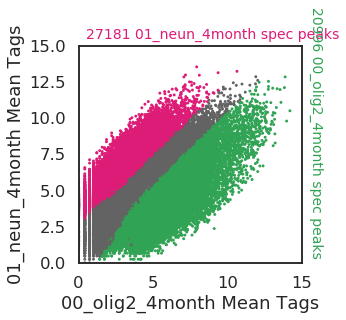

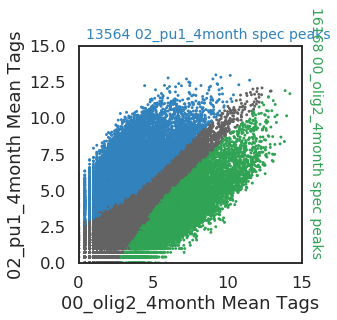

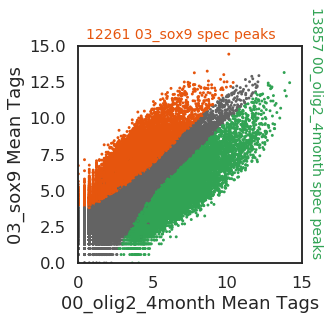

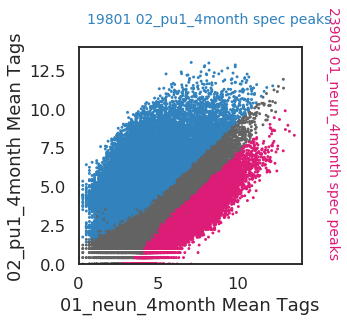

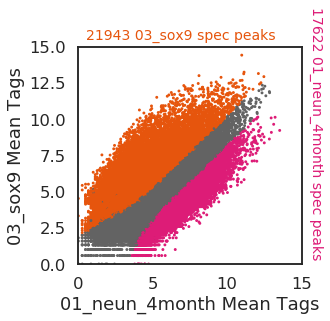

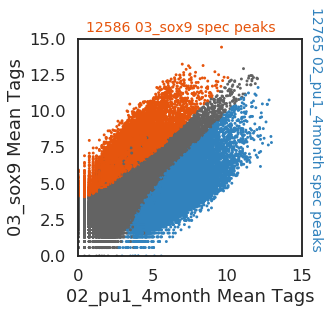

In [14]:
fc = 1
pval = 0.05

for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')

    de = comp_dict[key]
    ## filter lowly expressed peaks
    # filtered = (peak_mat.iloc[:, group[0]].mean(1) >= 5) | (peak_mat.iloc[:, group[1]].mean(1) >= 5)
    # de = de.reindex(peak_mat.index[filtered]).dropna()
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)))
    print('N genes upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
    # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=2, #de.log10p+0.05,
        c=dot_colors)

    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,15.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc > fc)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(15.5,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    # plt.close()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T ,method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y,
               c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

Trying to find other ways to plot these graphs

In [16]:
# density_scatter(de.g0_mean,
#                 de.g1_mean,
#                 s=1,
#                 cmap='gist_heat')

In [17]:
# sns.kdeplot(data=de.g0_mean,
#             data2=de.g1_mean,
#            levels=5,
#            color="k",
#            linewidths=1)

In [18]:
# fig, ax = plt.subplots(figsize=(4,4))
# ax.scatter(
#     x=de.g0_mean,
#     y=de.g1_mean,
#     s=1, #de.log10p+0.05,
#     c=dot_colors)
# sns.kdeplot(data=de.g0_mean,
#             data2=de.g1_mean,
#             levels=5,
#             color="w",
#             linewidths=1,
#             ax=ax)

# Clustered heatmap of differential enhancers

In [19]:
comps = comp_dict.keys()

## All enhancers - z scored

In [20]:
padj = 0.05
fc = 3

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[((de.adj_pval <= padj) & (np.abs(de.log2fc) >= fc)), :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=[hex_dict['olig2_4month'], hex_dict['olig2_4month'],
                           hex_dict['olig2_4month'], hex_dict['neun_4month'],
                           hex_dict['neun_4month'], hex_dict['neun_4month'],
                           hex_dict['neun_4month'], hex_dict['neun_4month'],
                           hex_dict['pu1_4month'], hex_dict['pu1_4month'],
                           hex_dict['pu1_4month'], hex_dict['sox9_4month'],
                           hex_dict['sox9_4month']],
               yticklabels=0,
               xticklabels=0)
plt.savefig('./figures/diff_peaks_clustermap_zscore.png', bbox_inches='tight')
plt.close()

40427


## All enhancers - log2 tag counts

In [21]:
padj = 0.05
fc = 3

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[((de.adj_pval <= padj) & (np.abs(de.log2fc) >= fc)), :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               # z_score=0,
               vmin=0,
               vmax=10,
               cmap='RdBu_r',
               col_colors=[hex_dict['olig2_4month'], hex_dict['olig2_4month'],
                           hex_dict['olig2_4month'], hex_dict['neun_4month'],
                           hex_dict['neun_4month'], hex_dict['neun_4month'],
                           hex_dict['neun_4month'], hex_dict['neun_4month'],
                           hex_dict['pu1_4month'], hex_dict['pu1_4month'],
                           hex_dict['pu1_4month'], hex_dict['sox9_4month'],
                           hex_dict['sox9_4month']],
               yticklabels=0,
               xticklabels=0)
plt.savefig('./figures/diff_peaks_clustermap_log2.png', bbox_inches='tight')
plt.close()

40427


## Distal enhancers - z score

36528


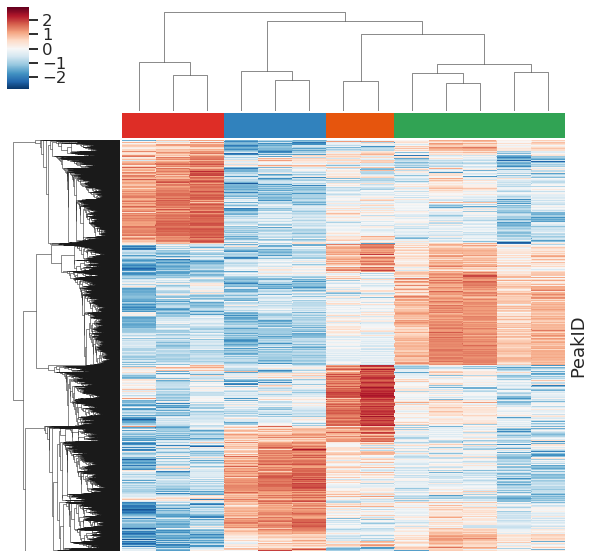

In [22]:
padj = 0.05
fc = 3

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= padj) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) >= 3000))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=[hex_dict['olig2_4month'], hex_dict['olig2_4month'],
                           hex_dict['olig2_4month'], hex_dict['neun_4month'],
                           hex_dict['neun_4month'], hex_dict['neun_4month'],
                           hex_dict['neun_4month'], hex_dict['neun_4month'],
                           hex_dict['pu1_4month'], hex_dict['pu1_4month'],
                           hex_dict['pu1_4month'], hex_dict['sox9_4month'],
                           hex_dict['sox9_4month']],
               yticklabels=0,
               xticklabels=0)
plt.savefig('./figures/diff_peaks_distal_clustermap_zscore.png', bbox_inches='tight')
plt.close()

## Distal enhancers - log2 tag counts

36528


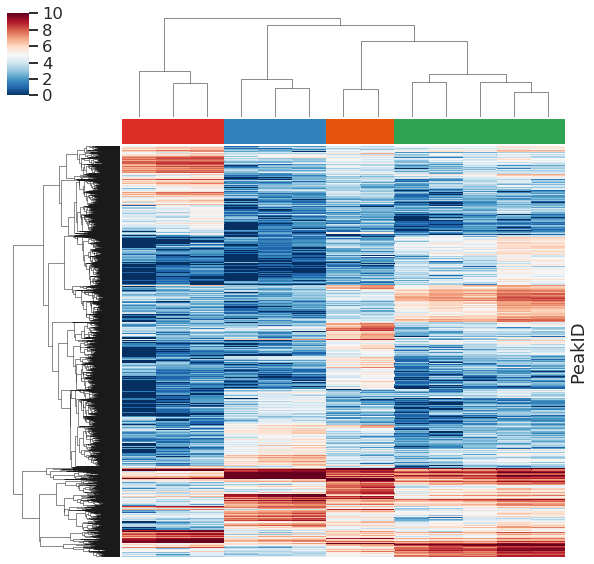

In [23]:
padj = 0.05
fc = 3

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= padj) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) >= 3000))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               # z_score=0,
               vmin=0,
               vmax=10,
               cmap='RdBu_r',
               col_colors=[hex_dict['olig2_4month'], hex_dict['olig2_4month'],
                           hex_dict['olig2_4month'], hex_dict['neun_4month'],
                           hex_dict['neun_4month'], hex_dict['neun_4month'],
                           hex_dict['neun_4month'], hex_dict['neun_4month'],
                           hex_dict['pu1_4month'], hex_dict['pu1_4month'],
                           hex_dict['pu1_4month'], hex_dict['sox9_4month'],
                           hex_dict['sox9_4month']],
               yticklabels=0,
               xticklabels=0)
plt.savefig('./figures/diff_peaks_distal_clustermap_log2.png', bbox_inches='tight')
plt.close()

## Promoters with Z Scores

In [24]:
padj = 0.05
fc = 3

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= padj) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) <= 5000))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=[hex_dict['olig2_4month'], hex_dict['olig2_4month'],
                           hex_dict['olig2_4month'], hex_dict['neun_4month'],
                           hex_dict['neun_4month'], hex_dict['neun_4month'],
                           hex_dict['neun_4month'], hex_dict['neun_4month'],
                           hex_dict['pu1_4month'], hex_dict['pu1_4month'],
                           hex_dict['pu1_4month'], hex_dict['sox9_4month'],
                           hex_dict['sox9_4month']],
               yticklabels=0,
               xticklabels=0)
plt.savefig('./figures/diff_promoters_clustermap_zscore.png', bbox_inches='tight')
plt.close()

5459


## Promoters - Log2 Tag Counts

In [25]:
padj = 0.05
fc = 3

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= padj) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) <= 500))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               # z_score=0,
               vmin=0,
               vmax=10,
               cmap='RdBu_r',
               col_colors=[hex_dict['olig2_4month'], hex_dict['olig2_4month'],
                           hex_dict['olig2_4month'], hex_dict['neun_4month'],
                           hex_dict['neun_4month'], hex_dict['neun_4month'],
                           hex_dict['neun_4month'], hex_dict['neun_4month'],
                           hex_dict['pu1_4month'], hex_dict['pu1_4month'],
                           hex_dict['pu1_4month'], hex_dict['sox9_4month'],
                           hex_dict['sox9_4month']],
               yticklabels=0,
               xticklabels=0)
plt.savefig('./figures/diff_promoters_clustermap_log2.png', bbox_inches='tight')
plt.close()

1365


# Extract peaks for an analysis in GREAT
____
Next we will pull the peaks associated with each cell type and write them out. This section is particularly useful when doing multiple pairwise comparisons at once but it still works well here. This will also write out bed files which can be analyzed using the GREAT tool from Stanford.

To do this we end up resetting the diff_peak files because we end up adding columns to make the above plots and I'm lazy

In [28]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_vw_output.txt',
    './merged_peaks/ann_raw_idr_vw_peaks_merged.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (80008, 31)
getDiffExpression selected transcripts (78242, 49)
annotatePeaks selected peaks (78242, 31)


In [29]:
# initialize dict and list of cell types
peak_lists = {}
cells = ['olig2',
         'neun',
         'pu1',
         'sox9']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing olig2 ...

0
For comp: 00_olig2_4month vs. 01_neun_4month
Union set at: 20996 peaks
Intersection set at: 20996 peaks

1
For comp: 00_olig2_4month vs. 02_pu1_4month
Union set at: 23855 peaks
Intersection set at: 13309 peaks

2
For comp: 00_olig2_4month vs. 03_sox9
Union set at: 24567 peaks
Intersection set at: 10287 peaks

3
For comp: 01_neun_4month vs. 02_pu1_4month
Union set at: 24567 peaks
Intersection set at: 10287 peaks

3
For comp: 01_neun_4month vs. 03_sox9
Union set at: 24567 peaks
Intersection set at: 10287 peaks

3
For comp: 02_pu1_4month vs. 03_sox9
Union set at: 24567 peaks
Intersection set at: 10287 peaks

Analyzing neun ...

0
For comp: 00_olig2_4month vs. 01_neun_4month
Union set at: 27181 peaks
Intersection set at: 27181 peaks

1
For comp: 00_olig2_4month vs. 02_pu1_4month
Union set at: 27181 peaks
Intersection set at: 27181 peaks

1
For comp: 00_olig2_4month vs. 03_sox9
Union set at: 27181 peaks
Intersection set at: 27181 peaks

1
For comp: 01_neun_4month vs. 

In [30]:
if not os.path.isdir('./great_analysis/'):
    os.mkdir('./great_analysis/')
    
if not os.path.isdir('./great_analysis/peak_files/'):
    os.mkdir('./great_analysis/peak_files/')
    
if not os.path.isdir('./great_analysis/bed_files/'):
    os.mkdir('./great_analysis/bed_files/')

Save each set of peaks derived from the list - in this case its just one set activated in each group

In [32]:
for key in peak_lists.keys():
    # save cell specific promoters
    diff_peak.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4].to_csv(
        './great_analysis/peak_files/'+key+'_act_peaks.txt',
        sep='\t')

set full set of peaks for background

In [34]:
diff_peak.iloc[:, :4].to_csv(
    './great_analysis/peak_files/atlas_all_peaks.txt',
    sep='\t')

In [35]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

In [36]:
%%bash
for peakfile in ./great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [45]:
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')

In [46]:
!cp ./great_analysis/bed_files/* ./bed_files/

In [47]:
!ls ./bed_files/

atlas_all_peaks.bed		  olig2_union_act_peaks.bed
background_peaks.bed		  pu1_intersection_act_peaks.bed
neun_intersection_act_peaks.bed   pu1_union_act_peaks.bed
neun_union_act_peaks.bed	  sox9_intersection_act_peaks.bed
olig2_intersection_act_peaks.bed  sox9_union_act_peaks.bed


In [50]:
%%bash

echo 'track name="NeuN_Intersection_H3K27Ac_peaks" description="NeuN Nuclei H3K27Ac intersection specific regions"' \
| cat - ./bed_files/neun_intersection_act_peaks.bed \
> temp && mv temp ./bed_files/neun_intersection_act_peaks.bed

echo 'track name="NeuN_Union_H3K27Ac_peaks" description="NeuN Nuclei H3K27Ac union specific regions"' \
| cat - ./bed_files/neun_union_act_peaks.bed \
> temp && mv temp ./bed_files/neun_union_act_peaks.bed

echo 'track name="Olig2_Intersection_H3K27Ac_peaks" description="Olig2 Nuclei H3K27Ac intersection specific regions"' \
| cat - ./bed_files/olig2_intersection_act_peaks.bed \
> temp && mv temp ./bed_files/olig2_intersection_act_peaks.bed

echo 'track name="Olig2_Union_H3K27Ac_peaks" description="Olig2 Nuclei H3K27Ac union specific regions"' \
| cat - ./bed_files/olig2_union_act_peaks.bed \
> temp && mv temp ./bed_files/olig2_union_act_peaks.bed

echo 'track name="PU1_Intersection_H3K27Ac_peaks" description="PU1 Nuclei H3K27Ac intersection specific regions"' \
| cat - ./bed_files/pu1_intersection_act_peaks.bed \
> temp && mv temp ./bed_files/pu1_intersection_act_peaks.bed

echo 'track name="PU1_Union_H3K27Ac_peaks" description="PU1 Nuclei H3K27Ac union specific regions"' \
| cat - ./bed_files/pu1_union_act_peaks.bed \
> temp && mv temp ./bed_files/pu1_union_act_peaks.bed

echo 'track name="Sox9_Intersection_H3K27Ac_peaks" description="Sox9 Nuclei H3K27Ac intersection specific regions"' \
| cat - ./bed_files/sox9_intersection_act_peaks.bed \
> temp && mv temp ./bed_files/sox9_intersection_act_peaks.bed

echo 'track name="Sox9_Union_H3K27Ac_peaks" description="Sox9 Nuclei H3K27Ac union specific regions"' \
| cat - ./bed_files/sox9_union_act_peaks.bed \
> temp && mv temp ./bed_files/sox9_union_act_peaks.bed